In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests 

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

# define constants
tickerpair="ETCUSDT"
interval="1m"
from aver6_funcs import get_data
import pickle,tqdm
from concurrent.futures import ThreadPoolExecutor
import concurrent

In [2]:
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)
len(subset_symbols),subset_symbols[1]

(352, 'XRP')

In [17]:
dfmpl_list_list = []
for iterr in tqdm.tqdm(range(190)):
    with open(f"2_0_0_analysisdata/2_0_3_dfmpl_list_{iterr:05d}.pkl","rb")as f:
        dfmpl_list = pickle.load(f)
    dfmpl_list_list.append( dfmpl_list.copy())

100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:19<00:00,  9.58it/s]


In [20]:
%%time
for symm in tqdm.tqdm(subset_symbols):
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    idx = np.unique( df_.index.values, return_index = True )[1]
    df__ = df_.iloc[idx]
    if not all(np.diff(df__.index,2).astype(float)==0):
        print(symm)

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 345/352 [00:19<00:00, 17.81it/s]

QUICKUSDT


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:19<00:00, 17.91it/s]

CPU times: total: 12.3 s
Wall time: 19.7 s


# concat the dfs, store into a list of dfs, also store a list of corresponding symbols

In [23]:
dfmpl_list = []

for idd,symm in enumerate(tqdm.tqdm(subset_symbols[:])):
    #if idd<110:continue
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    
    idx = np.unique( df_.index.values, return_index = True )[1]
    df__ = df_.iloc[idx]
    dfmpl_list.append( (df__.copy(),symm,idd) ) 

100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:19<00:00, 18.09it/s]


In [36]:
dfmpl,symm,idd = dfmpl_list[33]
dfmpl,symm,idd

(                        Open     High      Low    Close     Volume
 Date                                                              
 2023-03-30 04:01:00  0.04164  0.04169  0.04161  0.04168  2350833.0
 2023-03-30 04:02:00  0.04168  0.04168  0.04160  0.04163  1804493.0
 2023-03-30 04:03:00  0.04163  0.04169  0.04163  0.04167   459135.0
 2023-03-30 04:04:00  0.04168  0.04169  0.04161  0.04164   990118.0
 2023-03-30 04:05:00  0.04165  0.04169  0.04165  0.04165   988316.0
 ...                      ...      ...      ...      ...        ...
 2023-08-09 02:36:00  0.02364  0.02364  0.02363  0.02363   407422.0
 2023-08-09 02:37:00  0.02363  0.02364  0.02362  0.02362    77582.0
 2023-08-09 02:38:00  0.02362  0.02364  0.02362  0.02364   171785.0
 2023-08-09 02:39:00  0.02365  0.02365  0.02363  0.02363    79192.0
 2023-08-09 02:40:00  0.02363  0.02363  0.02362  0.02362   111700.0
 
 [190000 rows x 5 columns],
 'GALAUSDT',
 34)

In [44]:
v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
vol = (dfmpl.Volume*dfmpl.Open).values

In [45]:
vol

array([97888.68612, 75211.26824, 19113.79005, ...,  4057.5617 ,
        1872.8908 ,  2639.471  ])

In [46]:
np.percentile(vol,99)

138377.37595560012

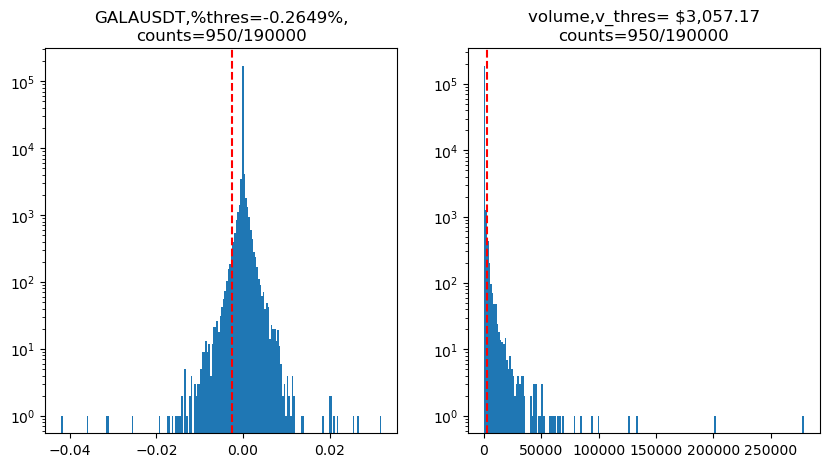

In [77]:
fig,axx=plt.subplots(1,2,figsize=(10,5))
ax=axx[0]
#percentile_threshold = np.percentile(v,99.9)
percentile_threshold = np.percentile(v,0.5)
ax.hist(v,bins=200);
ax.axvline(percentile_threshold,ls="--",c="r")
ax.set_title(f"{symm},%thres={percentile_threshold:.4%},\ncounts={sum(v<percentile_threshold)}/{len(v)}")
ax.set_yscale("log")
ax=axx[1]
ax.hist(vol,bins=200);
vol_threshold = np.percentile(vol,99.5)
ax.axvline(vol_threshold,ls="--",c="r")
ax.set_title(f"volume,v_thres= ${vol_threshold:3,g}\ncounts={sum(vol>vol_threshold)}/{len(vol)}")
ax.set_yscale("log")

# when price falls twice in a row, 

In [98]:
paramsWin = (-0.00689655,-0.00862069,1000000,2689655) # high%win params
paramsLowSD = (-0.00689655,-0.00172414,2689655,4379310) #lowSD 

In [128]:
import random

In [143]:
%%time 
collated_data_list = []
all_locs = [] 
    
for dfmpl, symb, _ in tqdm.tqdm(dfmpl_list):
    def validate_df(loc, df_v, v0_thres, v1_thres):
        v0 = df_v[loc, 0] * df_v[loc, 4]
        v1 = df_v[loc + 1, 0] * df_v[loc + 1, 4]
        return v0 > v0_thres and v1 > v1_thres
    v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
#     threshold1 = -0.0082#np.percentile(v,1)
#     threshold2 = -0.005# np.percentile(v,2)
#     v0_thres = np.percentile(vol,99)
#     v1_thres = np.percentile(vol,98)
    threshold1,threshold2,v0_thres,v1_thres = paramsWin
    df_v = dfmpl.values
    changes = (df_v[:, 3] - df_v[:, 0]) / df_v[:, 0] #open high low close volume
    a4_1 = np.logical_and(changes[1:] < threshold1, changes[:-1] < threshold2)
    locs = np.where(a4_1)[0]
    if locs.size == 0: continue
    chosen_locs = [loc for loc in locs if validate_df(loc, df_v, v0_thres, v1_thres)and loc<(190000-5)]
    if len(chosen_locs)==0:continue
    #[trade_locs.append(f"{loc}_{symb}") for loc in chosen_locs]
    collated_data = np.asarray([changes[loc:loc + 5] for loc in chosen_locs])
    [all_locs.append(loc)for loc in chosen_locs]
    collated_data_list.append(collated_data) 
                
collated_data = np.vstack(collated_data_list)
collated_data.shape

100%|███████████████████████████████████████████████████████████████████████████████| 347/347 [00:02<00:00, 163.10it/s]

CPU times: total: 1.17 s
Wall time: 2.14 s


(92, 5)

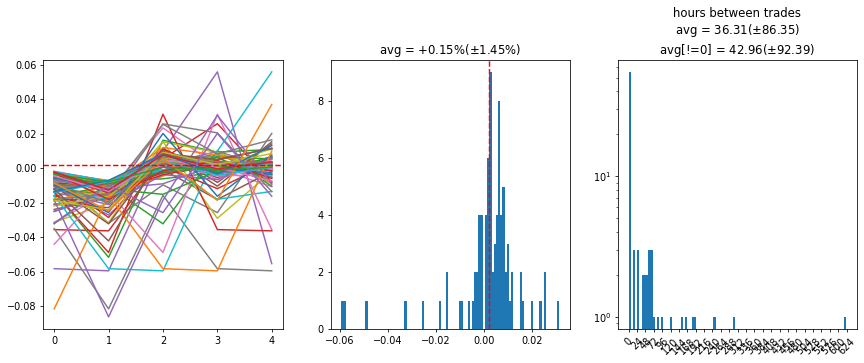

In [142]:
fig,axx=plt.subplots(1,3,figsize=(15,5),dpi=70)
ax=axx[0]
ax.plot(collated_data.T[:,random.sample(range(collated_data.shape[0]),min(200,collated_data.shape[0]))])
ax.axhline(0.002,ls="--",c="r")
ax=axx[1]
ax.hist(collated_data[:,2],bins=100);
ax.axvline(0.002,ls="--",c="r")
ax.set_title(f"avg = {np.mean(collated_data[:,2]):+.2%}($\pm${np.std(collated_data[:,2]):.2%})")
ax=axx[2]
hours_between_trades=np.diff(sorted(all_locs))/60
ax.hist(hours_between_trades,bins=100);
strr="hours between trades"
strr+=f"\navg = {np.mean(hours_between_trades):.2f}($\pm${np.std(hours_between_trades):.2f})"
strr+=f"\navg[!=0] = {np.mean(hours_between_trades[hours_between_trades!=0]):.2f}($\pm${np.std(hours_between_trades[hours_between_trades!=0]):.2f})"
ax.set_title(strr)
ax.set_yscale("log")
ax.set_xticks(np.arange(0,max(hours_between_trades)+24,24))
ax.set_xticklabels([f"{n:.0f}" for n in np.arange(0,max(hours_between_trades)+24,24)],rotation=45);

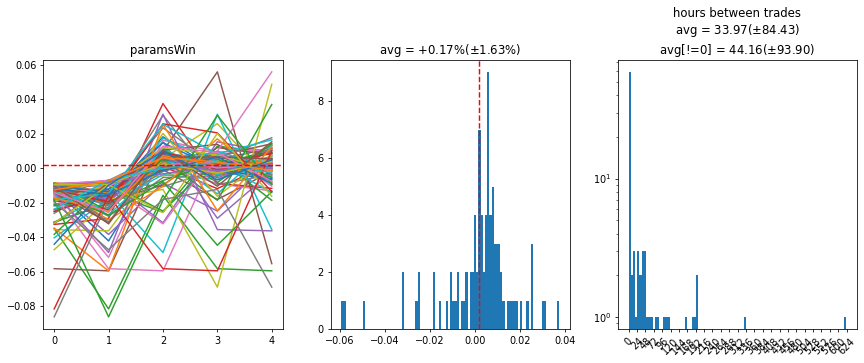

In [144]:
fig,axx=plt.subplots(1,3,figsize=(15,5),dpi=70)
ax=axx[0]
ax.set_title("paramsWin")
ax.plot(collated_data.T[:,random.sample(range(collated_data.shape[0]),min(200,collated_data.shape[0]))])
ax.axhline(0.002,ls="--",c="r")
ax=axx[1]
ax.hist(collated_data[:,2],bins=100);
ax.axvline(0.002,ls="--",c="r")
ax.set_title(f"avg = {np.mean(collated_data[:,2]):+.2%}($\pm${np.std(collated_data[:,2]):.2%})")
ax=axx[2]
hours_between_trades=np.diff(sorted(all_locs))/60
ax.hist(hours_between_trades,bins=100);
strr="hours between trades"
strr+=f"\navg = {np.mean(hours_between_trades):.2f}($\pm${np.std(hours_between_trades):.2f})"
strr+=f"\navg[!=0] = {np.mean(hours_between_trades[hours_between_trades!=0]):.2f}($\pm${np.std(hours_between_trades[hours_between_trades!=0]):.2f})"
ax.set_title(strr)
ax.set_yscale("log")
ax.set_xticks(np.arange(0,max(hours_between_trades)+24,24))
ax.set_xticklabels([f"{n:.0f}" for n in np.arange(0,max(hours_between_trades)+24,24)],rotation=45);

In [145]:
from plotting import plot_profits

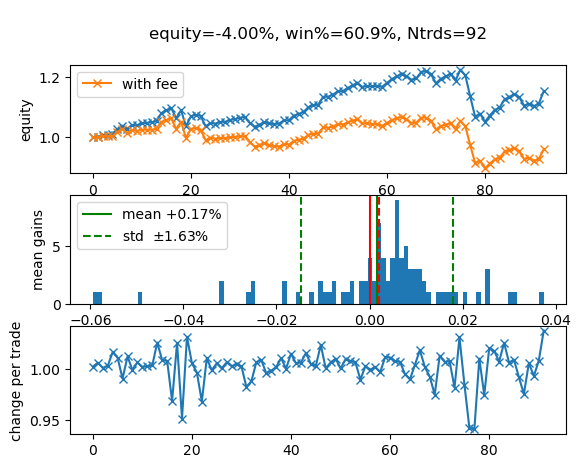

array([<Axes: title={'center': '\nequity=-4.00%, win%=60.9%, Ntrds=92\n'}, ylabel='equity'>,
       <Axes: ylabel='mean gains'>, <Axes: ylabel='change per trade'>],
      dtype=object)

In [146]:
plot_profits(collated_data[:,2])

In [72]:
%%time
#threshold=-0.0022
collated_data_list = []
all_locs = []
for dfmpl,tickerpair,_ in tqdm.tqdm(dfmpl_list[:]):
    v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
    vol = (dfmpl.Volume*dfmpl.Open).values
    per_threshold = np.percentile(v,0.5)
    vol_threshold = np.percentile(vol,99.5)
    a1=np.where(v<per_threshold)[0]
    a2=np.diff(a1)
    a3=np.where(a2==1)
    def validate_df(loc):
        df_ = dfmpl.iloc[loc:loc+2]
        v0,v1 = (df_.Open*df_.Volume).values
        if v0>vol_threshold and v1>vol_threshold:
            return True
        return False
    
    if len(a3)==0: continue
    locs=a1[a3] 
    if len(locs)==0: continue
    collected_locs = [loc for loc in locs if validate_df(loc) and loc<(190000-5)]
    collated_data = np.asarray([v[loc:loc+5] for loc in collected_locs])
    if len(collated_data)==0: continue
    #print(tickerpair,len(collated_data),[loc for loc in locs if validate_df(loc)])
    [all_locs.append(loc)for loc in collected_locs]
    collated_data_list.append(collated_data)
    #len(locs)
collated_data = np.vstack(collated_data_list)
collated_data.shape

100%|████████████████████████████████████████████████████████████████████████████████| 347/347 [00:14<00:00, 24.34it/s]

CPU times: total: 9.33 s
Wall time: 14.3 s


(13384, 5)

In [75]:
np.product(collated_data[:,2]+1-0.003)

3.66516746260094e-23

# trading implementation / algo

- subscribe to all data using websockets
- within each websocket instance, fetch data
- maintain a list of previous 2 candles
- once the current candle is determined to be changed, pop the list and append the new candle
    - then apply algorithm onto this list,
    - if criteria passed, send to master_trader.

In [23]:
import asyncio
from binance import AsyncClient, BinanceSocketManager
from binance.enums import *
import time
import datetime
from collections import Counter
import pickle

In [ ]:
master_list=[0 for _ in subset_symbols[:]]
async def main(symbol='BNBBTC',idd=0):
    global master_list
    #time.sleep(idd*)
    await asyncio.sleep(idd*0.25)
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client) 
    ts = bm.kline_socket(symbol, interval=KLINE_INTERVAL_1MINUTE) 
    print(f"sub{idd}",end=" ")
    prev="0000"
    async with ts as tscm:
        while True:
            res = await tscm.recv()
            #print(res)
            if res["e"]=="error":
                print(str(datetime.datetime.now())[11:-4],res)
                raise Exception(res)
            #print(res["k"]["s"],str(res["E"])[6:-3],str(res["k"]["T"])[6:-3],end="  ")
            master_list[idd]=str(res["k"]["T"])[6:-3]
            if idd==0:
                if prev != str(res["k"]["T"])[6:-3]:
                    print(str(datetime.datetime.now())[11:-4],master_list[-3:],Counter(master_list))
                    prev = str(res["k"]["T"])[6:-3]
    await client.close_connection()

In [ ]:
loop = asyncio.get_event_loop()
#loop.run_until_complete(main())
for idd,s in enumerate(subset_symbols[:]):
    asyncio.run_coroutine_threadsafe(main(s+"USDT",idd), loop)
    #time.sleep(0.4)